Alzheimer's Dataset ( 4 class of Images)

Dataset source: https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 94% 32.0M/34.1M [00:01<00:00, 19.6MB/s]
100% 34.1M/34.1M [00:01<00:00, 30.4MB/s]


In [4]:
! unzip alzheimers-dataset-4-class-of-images.zip 

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import keras
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical


In [79]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


In [80]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/test',
                                                  target_size = (224,224))

Found 1279 images belonging to 4 classes.


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


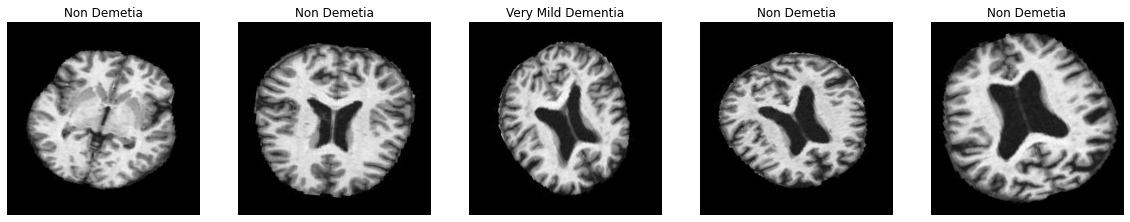

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

Building and training the model

In [8]:
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58900480/58889256 [==============================] - 2s 0us/step


In [9]:
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
from keras.models import Model
x = base_model.output
x = Dropout(0.5)(x)
x= Flatten()(x)
x = BatchNormalization()(x)
x = Dense(2048,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(4,activation='softmax')(x)
model = Model(base_model.input,predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.4004 - auc: 0.7713
Epoch 00001: val_auc improved from -inf to 0.59624, saving model to ./best_weights.hdf5
33/33 [==============================] - 153s 3s/step - loss: 1.4004 - auc: 0.7713 - val_loss: 1.8147 - val_auc: 0.5962
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 1.1839 - auc: 0.8089
Epoch 00002: val_auc improved from 0.59624 to 0.69427, saving model to ./best_weights.hdf5
33/33 [==============================] - 71s 2s/step - loss: 1.1839 - auc: 0.8089 - val_loss: 1.3443 - val_auc: 0.6943
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 1.0761 - auc: 0.8288
Epoch 00003: val_auc improved from 0.69427 to 0.75990, saving model to ./best_weights.hdf5
33/33 [==============================] - 71s 2s/step - loss: 1.0761 - auc: 0.8288 - val_loss: 1.1915 - val_auc: 0.7599
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.9838 - auc: 0.8461
Epoch 00004:

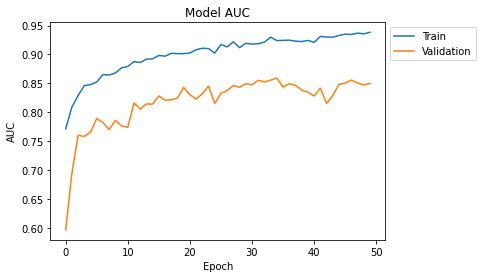

In [ ]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

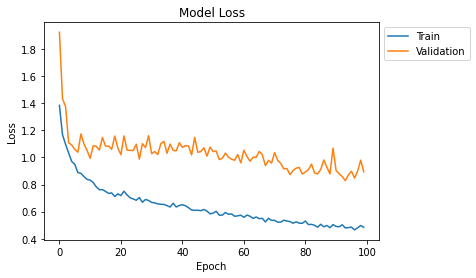

In [ ]:
# Summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/AI/Alzheimer's/model1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI/Alzheimer's/model1/assets


In [13]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

40/40 [==============================] - 36s 476ms/step - loss: 0.7877 - auc: 0.8984
Test accuracy : 0.8984413146972656


In [12]:
model = keras.models.load_model("/content/drive/MyDrive/AI/Alzheimer's/model1")

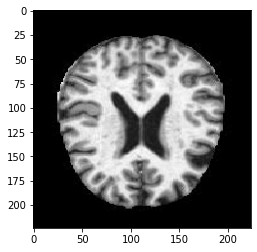

In [18]:
from keras.preprocessing.image import load_img, img_to_array
_img = load_img("/content/Alzheimer_s Dataset/test/NonDemented/26 (63).jpg",target_size=(224,224))
plt.imshow(_img)
plt.show()

In [19]:
from keras.applications.vgg16 import VGG16, preprocess_input
img               = img_to_array(_img)
img               = preprocess_input(img)
y_pred            = model.predict(img[np.newaxis,...])
print(np.argmax(y_pred))

2


#DL interpretability
Gradcam

In [81]:
imgs, labels = next(iter(test_dataset))

In [82]:
for layer in model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
dropout_3
flatten_1
batch_normalization_3
dense_3
batch_normalization_4
activation_2
dropout_4
dense_4
batch_normalization_5
activation_3
dropout_5
dense_5


In [23]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = [layer.name for layer in model.layers][18:]

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [68]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        
        

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    #grads = tape.gradient(score, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [83]:
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

print("Predicted label:", pred_labels)
print("Original labels: ",tf.argmax(labels, axis = -1))

Predicted label: tf.Tensor([2 0 2 2 3 3 0 3 2 2 2 2 0 2 3 3 3 2 2 3 2 0 3 2 0 2 3 3 2 3 3 2], shape=(32,), dtype=int64)
Original labels:  tf.Tensor([0 3 2 2 2 3 0 1 3 2 3 2 0 2 2 2 3 2 2 2 2 2 2 3 0 2 3 0 2 2 2 0], shape=(32,), dtype=int64)


In [84]:
heatmaps = []

for img in imgs:
    heatmap = make_gradcam_heatmap(
    tf.expand_dims(img,axis=0),
        base_model, model, 
        last_conv_layer_name, 
        classifier_layer_names
  )
    heatmaps.append(heatmap)



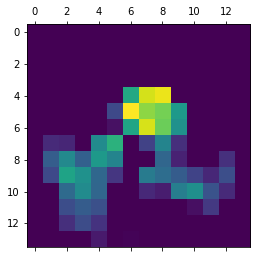

In [85]:
# Display heatmap
plt.matshow(heatmaps[0])
plt.show()

Predicted label: NonDemented
True label: MildDemented


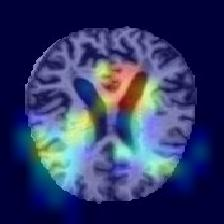

Binarized image


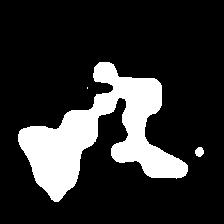

Predicted label: MildDemented
True label: VeryMildDemented


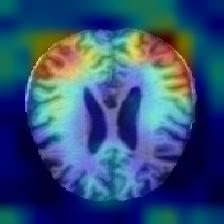

Binarized image


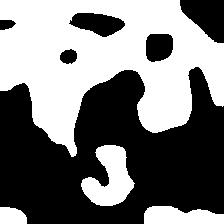

Predicted label: NonDemented
True label: NonDemented


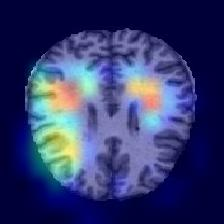

Binarized image


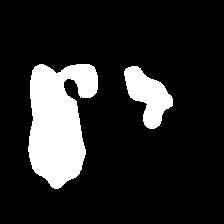

Predicted label: NonDemented
True label: NonDemented


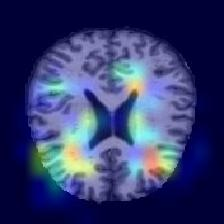

Binarized image


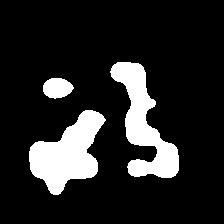

Predicted label: VeryMildDemented
True label: NonDemented


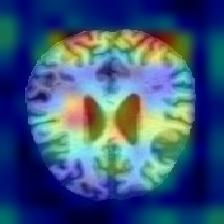

Binarized image


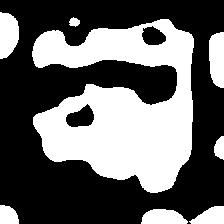

Predicted label: VeryMildDemented
True label: VeryMildDemented


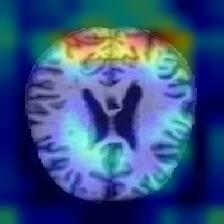

Binarized image


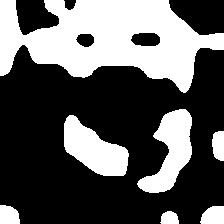

Predicted label: MildDemented
True label: MildDemented


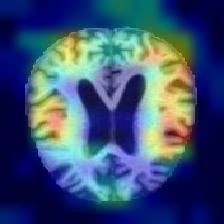

Binarized image


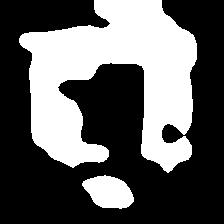

Predicted label: VeryMildDemented
True label: ModerateDemented


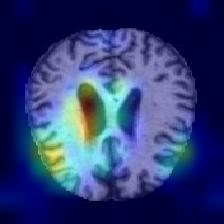

Binarized image


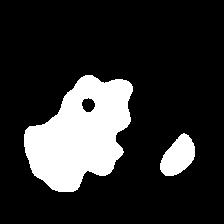

Predicted label: NonDemented
True label: VeryMildDemented


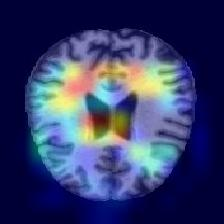

Binarized image


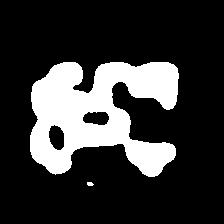

Predicted label: NonDemented
True label: NonDemented


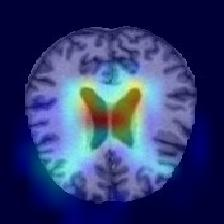

Binarized image


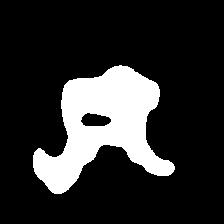

Predicted label: NonDemented
True label: VeryMildDemented


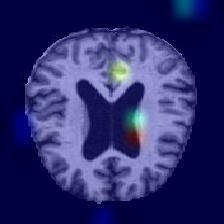

Binarized image


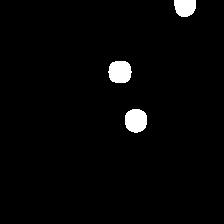

Predicted label: NonDemented
True label: NonDemented


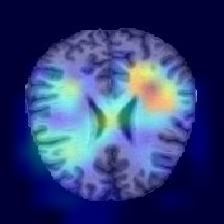

Binarized image


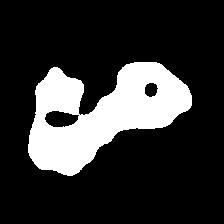

Predicted label: MildDemented
True label: MildDemented


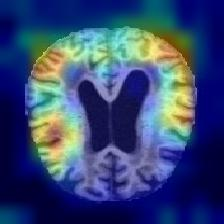

Binarized image


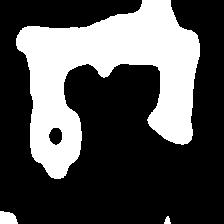

Predicted label: NonDemented
True label: NonDemented


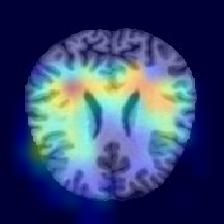

Binarized image


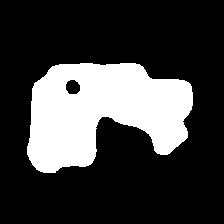

Predicted label: VeryMildDemented
True label: NonDemented


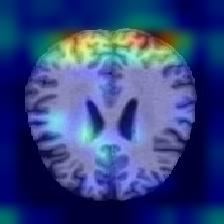

Binarized image


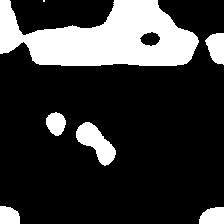

Predicted label: VeryMildDemented
True label: NonDemented


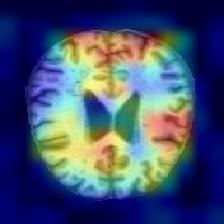

Binarized image


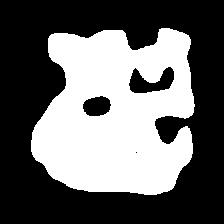

Predicted label: VeryMildDemented
True label: VeryMildDemented


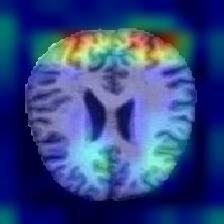

Binarized image


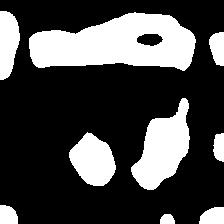

Predicted label: NonDemented
True label: NonDemented


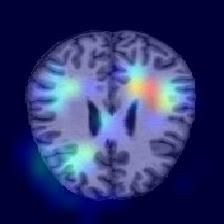

Binarized image


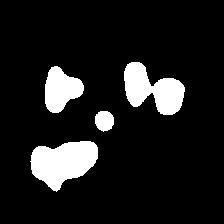

Predicted label: NonDemented
True label: NonDemented


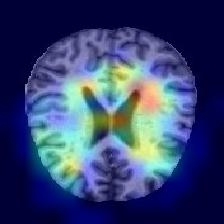

Binarized image


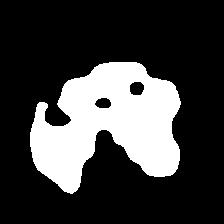

Predicted label: VeryMildDemented
True label: NonDemented


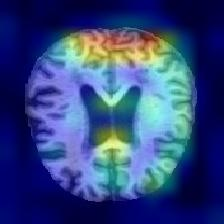

Binarized image


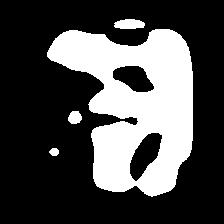

Predicted label: NonDemented
True label: NonDemented


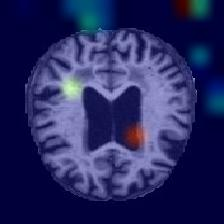

Binarized image


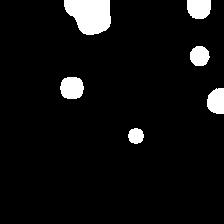

Predicted label: MildDemented
True label: NonDemented


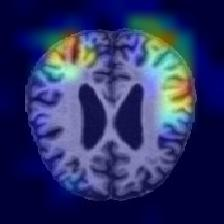

Binarized image


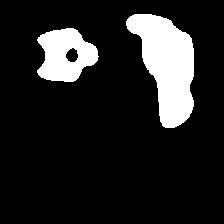

Predicted label: VeryMildDemented
True label: NonDemented


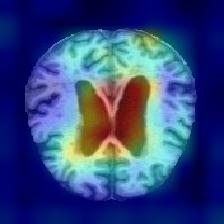

Binarized image


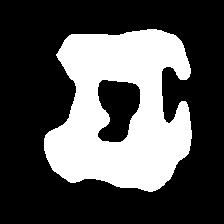

Predicted label: NonDemented
True label: VeryMildDemented


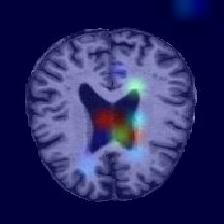

Binarized image


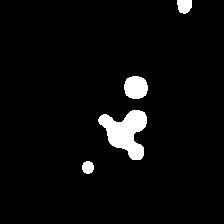

Predicted label: MildDemented
True label: MildDemented


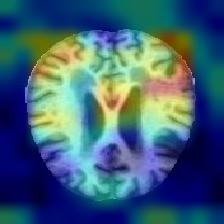

Binarized image


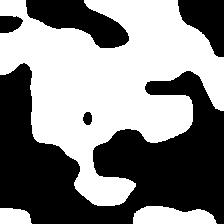

Predicted label: NonDemented
True label: NonDemented


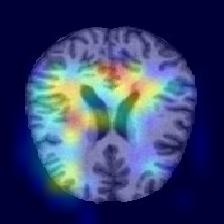

Binarized image


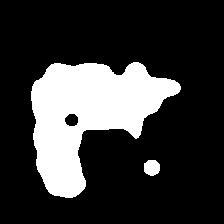

Predicted label: VeryMildDemented
True label: VeryMildDemented


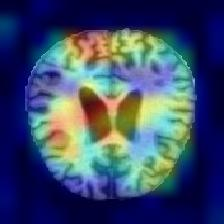

Binarized image


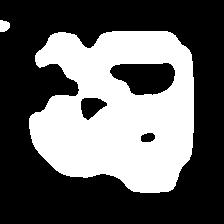

Predicted label: VeryMildDemented
True label: MildDemented


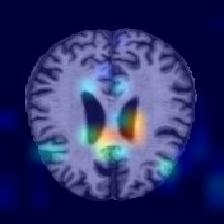

Binarized image


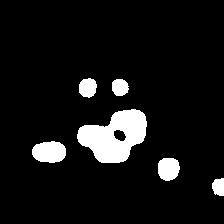

Predicted label: NonDemented
True label: NonDemented


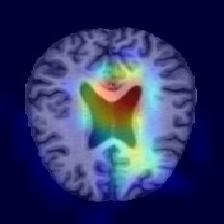

Binarized image


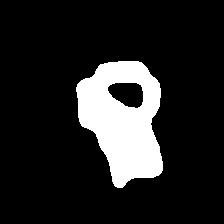

Predicted label: VeryMildDemented
True label: NonDemented


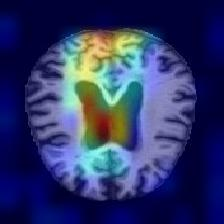

Binarized image


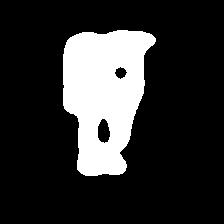

Predicted label: VeryMildDemented
True label: NonDemented


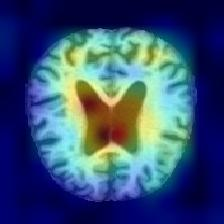

Binarized image


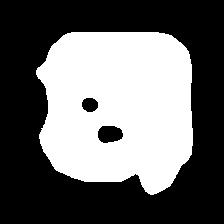

Predicted label: NonDemented
True label: MildDemented


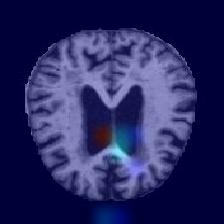

Binarized image


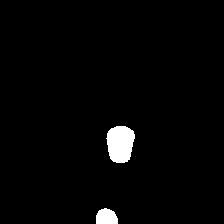

In [86]:
import cv2
from PIL import Image as im 
from pathlib import Path
i=0
for img, pred_label, true_label, heatmap in zip(imgs, pred_labels, labels, heatmaps): 
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap_img = jet_heatmap.resize((img.shape[1], img.shape[0]))
    save_path = f"heatmap{i}.jpg"
    jet_heatmap_img.save(save_path)
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap_img)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.003 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    save_path = f"saved_img{i}.jpg"
    superimposed_img.save(save_path)

    # Display Grad CAM
    pred_file_path = np.argmax(test_dataset.labels == pred_label)
    pred_label_name = Path(test_dataset.filepaths[pred_file_path]).parent.name

    true_file_path = np.argmax(test_dataset.labels == tf.argmax(true_label))
    true_label_name = Path(test_dataset.filepaths[true_file_path]).parent.name

    print("Predicted label:",pred_label_name)
    print("True label:", true_label_name)
    display(Image(save_path))
    
    #Display the binarized heatmap
    image1 = cv2.imread(f'heatmap{i}.jpg')
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)     
    img= im.fromarray(thresh1)     
    save_path = f"binary{i}.jpg"
    img.save(save_path)
    print("Binarized image")
    display(Image(save_path))
    i+=1